In [5]:
# =============================================================================
# Import
# =============================================================================
import cv2
import os
import glob
import numpy as np
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt

# To get reproducable results with the same training setting random seed
SEED = 42
np.random.seed(SEED)

# Flags
plots_on = True
test_on_specific_image = True

In [6]:
# =============================================================================
# Define functions
# =============================================================================
# Change image size and convert to grayscale images
def pic_prep (image, x, y):
  image = cv2.resize(image, (y,x)) # change image size
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
  image = image / 255 # image normalization
  return image

# Shuffle images
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# Save training info in file.txt
def write_infotext(filepath,
                   image_size,
                   num_neurons_per_layer,
                   batch_size,
                   epochs,
                   history=[0,1],
                   testresult=['tr']):
    with open(filepath + 'info.txt','w') as txt:
        txt.write('############ SPECS ############\n'
                  '\n'
                  'IMG Resolution: ' f'{image_size}\n'
                  'Neurons per Layer: ' f'{num_neurons_per_layer}\n'
                  'Batch Size: ' f'{batch_size}\n'
                  'Epochs: ' f'{epochs}\n'
                  '\n'
                  '\n'
                  '########### HISTORY ###########\n'
                  '\n'
                  'Test score: ' f'{history[0]}\n'
                  'Test accuracy: ' f'{history[1]}\n'
                  '\n'
                  '\n'
                  '########### TESTING ###########\n'
                  '\n'
                  'Test1: Vorfahrt, Test2: VorfahrtGewaehren, Test3: Fuenfzig, Test4: Achtung\n'
                  '\n')
        
        for i in range(0,len(testresult),1):
            txt.write(f'{testresult[i]}\n')

        txt.write('\n'
                  '###############################\n')
                  

# todo: only show output of training for every 10 epochs
# Add callback to only print loss etc. after e.g. 10 epochs:
# https://stackoverflow.com/questions/44931689/how-to-disable-printing-reports-after-each-epoch-in-keras
class callback_print(callbacks.Callback):
    SHOW_NUMBER = 10
    counter = 0
    epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_train_batch_end(self, batch, logs=None):
        if self.counter == self.SHOW_NUMBER or self.epoch == 1:
            print('Epoch: ' + str(self.epoch) + ' loss: ' + str(logs['loss']))
            if self.epoch > 1:
                self.counter = 0
        self.counter += 1

In [7]:
# =============================================================================
# Function with some hypterparameters to change for comparison
# =============================================================================
def train_signs_model(num_training=0,
                      image_size=[32, 28, 1],
                      num_neurons_per_layer=[64,32,16,13],
                      batch_size=4,
                      epochs=300):
    # =============================================================================
    # Declare variables
    # =============================================================================
    img_size_x = image_size[0]
    img_size_y = image_size[1]
    img_dim = img_size_x * img_size_y
    

    # Change the following path to your dataset path
    path = '/home/pi/Documents'
    #path = '/home/metzgeka/ml_project/datasets'
    dataset_dir = path + '/Verkehrszeichenerkennung/projekt_hk_kt/dataset/'
    checkpoint_filepath = path + '/Verkehrszeichenerkennung/projekt_hk_kt/chpt/' + f'{num_training}/'
    os.makedirs(checkpoint_filepath, exist_ok=True)
    img_path = glob.glob(dataset_dir + '*/*.jpg')
    anz_data = len(img_path)
    #print(img_path)

    # =============================================================================
    # Get number of data (image/label) 
    # =============================================================================
    anz_data = int(anz_data) - 1
    dataset = np.zeros((anz_data, img_size_x, img_size_y), dtype=float)
    ground_truth = np.zeros((anz_data), dtype=float)
    #print("dataset size:", anz_data)

    # =============================================================================
    # Callback for training
    # =============================================================================
    model_filepath=checkpoint_filepath + str(num_training) + '-chpt.model.keras'

    model_checkpoint_callback = callbacks.ModelCheckpoint(
        model_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='auto',
        save_best_only=True,
        verbose = 1)
    
    # =============================================================================
    # Read dataset
    # =============================================================================
    for i in range(0, anz_data, 1):
        image = cv2.imread(img_path[i])                         # read image
        image = pic_prep(image, img_size_x, img_size_y)         # prepare image
        dataset[i,:,:] = image                                  # 2d-image to 3d-array
        gt_path = os.path.normpath(img_path[i]).split(os.sep)   # splitting paths for folder numbers
        ground_truth[i] = int(gt_path[-2])                      # ground truth for all images
    #print(ground_truth)

    # =============================================================================
    # Prepare dataset: train set (80%) and test set (20%)
    # =============================================================================
    #dataset = dataset.reshape(anz_data, img_dim) # convert into 2d array (all pixel in one row)
    ground_truth = ground_truth.reshape(anz_data, 1)

    dataset, ground_truth = unison_shuffle(dataset, ground_truth)

    trainset = np.random.choice(dataset.shape[0],
                                int(dataset.shape[0]*0.80), 
                                replace=False)
    train_data = dataset[trainset,:]
    train_gt = ground_truth[trainset]
    train_gt = utils.to_categorical(train_gt, 6)  #geändert auf 6 klassen von 13

    testset = np.delete(np.arange(0, len(ground_truth) ), 
                        trainset) 
    test_data = dataset[testset,:]
    test_gt = ground_truth[testset]
    test_gt = utils.to_categorical(test_gt, 6)  #auch geändert
    #print(ground_truth)
    #print(dataset)
    #print(trainset)
    #print(train_data)
    #print(train_gt)

    # =============================================================================
    # Create neural network with e.g. 4 layers and (64, 32, 16, 4) neurons per layer.
    # =============================================================================
    img_shape = (image_size[0],image_size[1],1)

    model = models.Sequential()
    model.add(layers.Conv2D(6, (5,5), activation='tanh', padding='same', input_shape=img_shape))
    model.add(layers.AveragePooling2D((2,2)))
    model.add(layers.Conv2D(16, (5,5), activation='tanh'))
    model.add(layers.AveragePooling2D((2,2)))
    model.add(layers.Conv2D(120, (5,5), activation='tanh'))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_neurons_per_layer[0], activation='tanh'))
    model.add(layers.Dense(num_neurons_per_layer[1], activation='softmax'))
    model.compile(loss='mean_squared_error', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    # =============================================================================
    # Train the neuronal network e.g. for e.g. 300 epochs.
    # =============================================================================
    history = model.fit(train_data, 
                        train_gt, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=0, 
                        shuffle=True, 
                        validation_data=(test_data, test_gt), 
                        callbacks=[model_checkpoint_callback])
    
    # =============================================================================
    # Plot train and val accuracy.
    # =============================================================================
    if plots_on:
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.savefig(checkpoint_filepath + 'acc.png', dpi=300, bbox_inches='tight')
        plt.show()

        # =========================================================================
        # Plot train and val loss.
        # =========================================================================
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='lower left')
        plt.savefig(checkpoint_filepath + 'loss.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    if test_on_specific_image:
        # =========================================================================
        # Load pretrained dataset weights to e.g. test on new (unseen) data.
        # =========================================================================
        model.load_weights(model_filepath)   

        # =========================================================================
        # Test dataset on xxx.
        # =========================================================================
        score = model.evaluate(test_data, test_gt, verbose=1)
        print('Test score:', score[0])
        print('Test accuracy:', score[1])       

        # =========================================================================
        # Testing on a single image.
        # =========================================================================

        result = ['tr0','tr1','tr2','tr3','tr4','tr5']
        
        # Class Labels
        class_lables = ['Achtung',
                        #'Achtzig',
                        #'Baustelle',
                        #'Dreisig',
                        #'DurchfahrtVerboten',
                        'Fuenfzig',                        # geändert auf 6 klassen
                        'Hundert',
                        #'Hundertdreisig',
                        #'Sechzig',
                        #'Siebzig',
                        'Stop',
                        'Vorfahrt',
                        'VofahrtGewaehren']
        for i in range(0,6,1):
            data_pred = np.zeros((1, img_size_x, img_size_y), dtype=float)
            img_pred = cv2.imread('/home/pi/Documents/Verkehrszeichenerkennung/projekt_hk_kt/testdata/' + f'{i}')
            img_pred = pic_prep(img_pred, img_size_x, img_size_y)
            data_pred[0,:,:] = img_pred
            #data_pred = data_pred.reshape(1,img_dim)
            #print(np.shape(data_pred))
            probs = model.predict(data_pred)
            result[i] = [{label: f'{prob * 100:.2f}%' 
                        for label, prob in zip(class_lables, sample)}
                        for sample in probs]
        
            print('Percentages per class:\n')
            print(f'{result[i]}\n')
        
        # =============================================================================
        # Output class: 
        # =============================================================================
        """
        max_res = 0
        res_index = 12
        for i in range(0, 12, 1):
            if probs[0,i] > max_res:
                max_res = probs[0,i]
                res_index = i

        if res_index == 0:
            print('Schild: 'f'{class_lables[0]} erkannt')
        elif res_index == 1:
            print('Schild: 'f'{class_lables[1]} erkannt')
        elif res_index == 2:
            print('Schild: 'f'{class_lables[2]} erkannt')
        elif res_index == 3:
            print('Schild: 'f'{class_lables[3]} erkannt')
        elif res_index == 4:
            print('Schild: 'f'{class_lables[4]} erkannt')
        elif res_index == 5:
            print('Schild: 'f'{class_lables[5]} erkannt')
        elif res_index == 6:
            print('Schild: 'f'{class_lables[6]} erkannt')
        elif res_index == 7:
            print('Schild: 'f'{class_lables[7]} erkannt')
        elif res_index == 8:
            print('Schild: 'f'{class_lables[8]} erkannt')
        elif res_index == 9:
            print('Schild: 'f'{class_lables[9]} erkannt')
        elif res_index == 10:
            print('Schild: 'f'{class_lables[10]} erkannt')
        elif res_index == 11:
            print('Schild: 'f'{class_lables[11]} erkannt')
        elif res_index == 12:
            print('Schild: 'f'{class_lables[12]} erkannt')
        elif res_index == 13:
            print('Error!')
        """
    write_infotext(checkpoint_filepath,
                   image_size,
                   num_neurons_per_layer,
                   batch_size,
                   epochs,
                   score,
                   result)

Training 18 with image size [64, 56] and [128, 6] neurons per layer

Epoch 1: val_accuracy improved from -inf to 0.26471, saving model to /home/pi/Documents/Verkehrszeichenerkennung/projekt_hk_kt/chpt/18/18-chpt.model.keras

Epoch 2: val_accuracy did not improve from 0.26471

Epoch 3: val_accuracy improved from 0.26471 to 0.32353, saving model to /home/pi/Documents/Verkehrszeichenerkennung/projekt_hk_kt/chpt/18/18-chpt.model.keras

Epoch 4: val_accuracy did not improve from 0.32353

Epoch 5: val_accuracy did not improve from 0.32353

Epoch 6: val_accuracy did not improve from 0.32353

Epoch 7: val_accuracy did not improve from 0.32353

Epoch 8: val_accuracy did not improve from 0.32353

Epoch 9: val_accuracy did not improve from 0.32353

Epoch 10: val_accuracy did not improve from 0.32353

Epoch 11: val_accuracy did not improve from 0.32353

Epoch 12: val_accuracy did not improve from 0.32353

Epoch 13: val_accuracy did not improve from 0.32353

Epoch 14: val_accuracy did not improve f

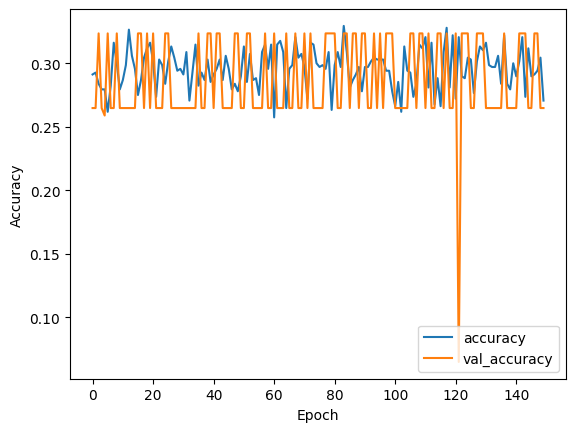

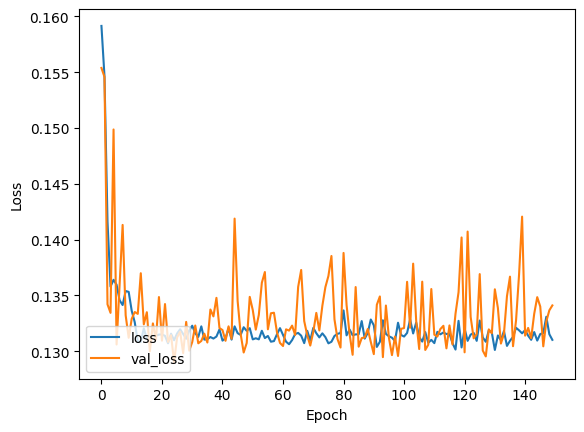

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3055 - loss: 0.1351
Test score: 0.13419827818870544
Test accuracy: 0.3235294222831726
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Percentages per class:

[{'Achtung': '9.67%', 'Fuenfzig': '0.00%', 'Hundert': '18.80%', 'Stop': '10.71%', 'Vorfahrt': '21.03%', 'VofahrtGewaehren': '39.79%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Percentages per class:

[{'Achtung': '9.67%', 'Fuenfzig': '0.00%', 'Hundert': '18.80%', 'Stop': '10.71%', 'Vorfahrt': '21.03%', 'VofahrtGewaehren': '39.79%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Percentages per class:

[{'Achtung': '9.67%', 'Fuenfzig': '0.00%', 'Hundert': '18.80%', 'Stop': '10.71%', 'Vorfahrt': '21.03%', 'VofahrtGewaehren': '39.79%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Percentages per class:

[{'Achtung': '9.67%', 'Fuenfzig': '0.00%', 'Hundert': '18.80%', 'Stop': '10.71%', 'Vorfahrt': '21.03%', 'VofahrtGewaehren': '39.79%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Percentages per class:

[{'Ach

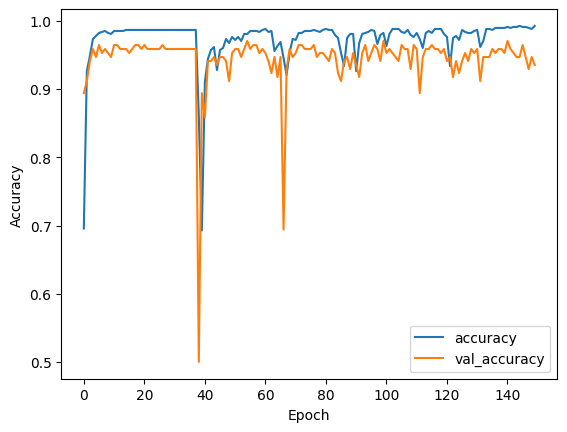

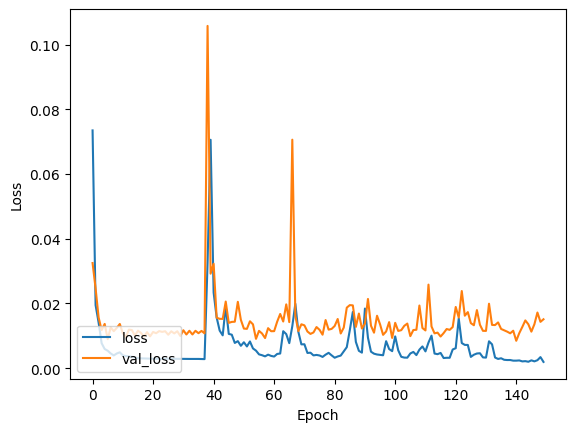

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9752 - loss: 0.0084
Test score: 0.009057685732841492
Test accuracy: 0.970588207244873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Percentages per class:

[{'Achtung': '1.25%', 'Fuenfzig': '0.01%', 'Hundert': '0.27%', 'Stop': '1.64%', 'Vorfahrt': '96.75%', 'VofahrtGewaehren': '0.08%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Percentages per class:

[{'Achtung': '0.17%', 'Fuenfzig': '0.02%', 'Hundert': '0.01%', 'Stop': '0.10%', 'Vorfahrt': '99.69%', 'VofahrtGewaehren': '0.00%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Percentages per class:

[{'Achtung': '0.03%', 'Fuenfzig': '22.02%', 'Hundert': '77.88%', 'Stop': '0.00%', 'Vorfahrt': '0.03%', 'VofahrtGewaehren': '0.04%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Percentages per class:

[{'Achtung': '0.02%', 'Fuenfzig': '0.38%', 'Hundert': '3.86%', 'Stop': '0.00%', 'Vorfahrt': '2.12%', 'VofahrtGewaehren': '93.61%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Percentages per class:

[{'Achtung': '0.0

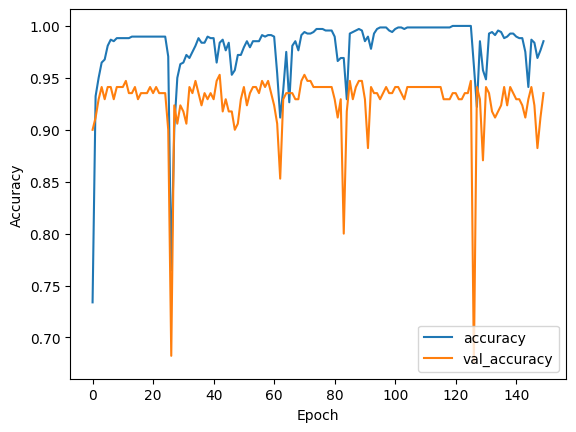

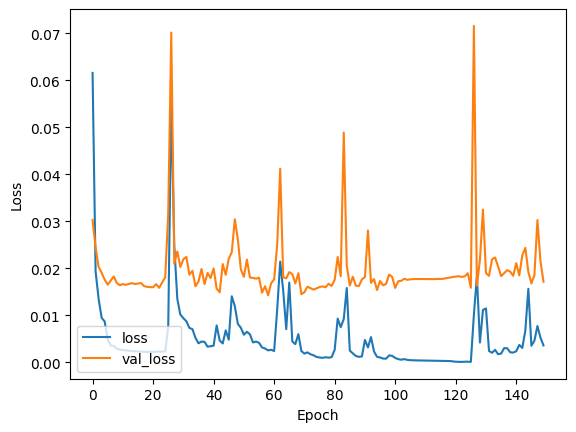

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9281 - loss: 0.0219
Test score: 0.014885764569044113
Test accuracy: 0.9529411792755127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Percentages per class:

[{'Achtung': '73.33%', 'Fuenfzig': '0.31%', 'Hundert': '0.32%', 'Stop': '14.70%', 'Vorfahrt': '11.33%', 'VofahrtGewaehren': '0.00%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Percentages per class:

[{'Achtung': '0.34%', 'Fuenfzig': '0.01%', 'Hundert': '0.01%', 'Stop': '0.00%', 'Vorfahrt': '99.64%', 'VofahrtGewaehren': '0.00%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Percentages per class:

[{'Achtung': '0.00%', 'Fuenfzig': '0.55%', 'Hundert': '98.54%', 'Stop': '0.00%', 'Vorfahrt': '0.89%', 'VofahrtGewaehren': '0.01%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Percentages per class:

[{'Achtung': '0.00%', 'Fuenfzig': '0.01%', 'Hundert': '0.09%', 'Stop': '0.00%', 'Vorfahrt': '97.11%', 'VofahrtGewaehren': '2.79%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Percentages per class:

[{'Achtung': '0.

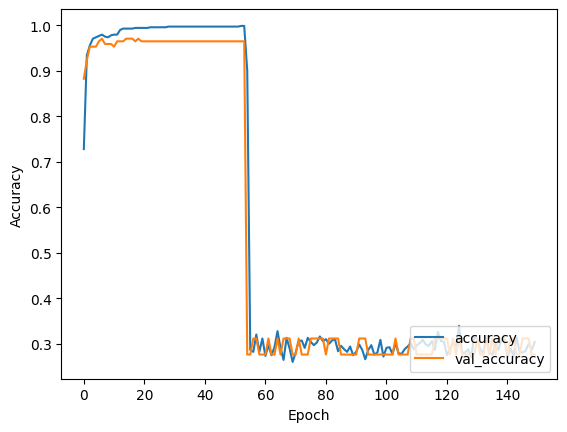

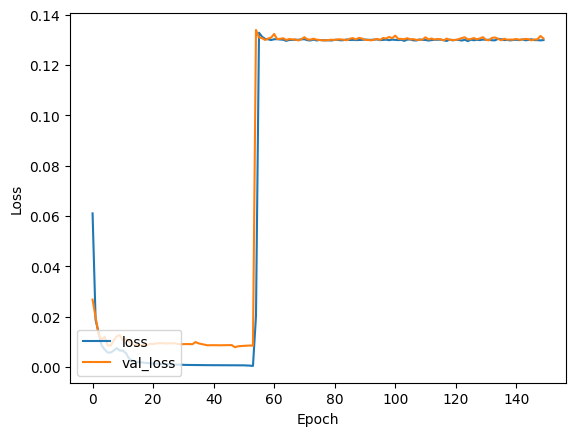

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9786 - loss: 0.0068
Test score: 0.008446418680250645
Test accuracy: 0.970588207244873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Percentages per class:

[{'Achtung': '5.97%', 'Fuenfzig': '0.04%', 'Hundert': '0.17%', 'Stop': '1.91%', 'Vorfahrt': '90.85%', 'VofahrtGewaehren': '1.07%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Percentages per class:

[{'Achtung': '1.21%', 'Fuenfzig': '11.74%', 'Hundert': '0.45%', 'Stop': '5.95%', 'Vorfahrt': '80.63%', 'VofahrtGewaehren': '0.03%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Percentages per class:

[{'Achtung': '0.06%', 'Fuenfzig': '38.15%', 'Hundert': '56.66%', 'Stop': '2.59%', 'Vorfahrt': '2.11%', 'VofahrtGewaehren': '0.43%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Percentages per class:

[{'Achtung': '0.06%', 'Fuenfzig': '2.46%', 'Hundert': '2.78%', 'Stop': '0.03%', 'Vorfahrt': '60.09%', 'VofahrtGewaehren': '34.59%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Percentages per class:

[{'Achtung': '0.

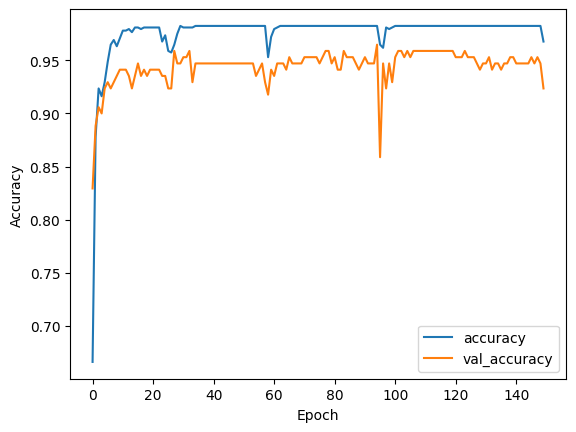

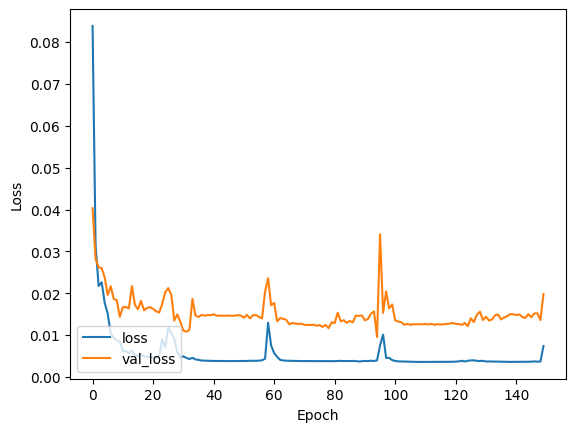

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9748 - loss: 0.0064
Test score: 0.009554044343531132
Test accuracy: 0.9647058844566345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Percentages per class:

[{'Achtung': '0.00%', 'Fuenfzig': '0.55%', 'Hundert': '0.00%', 'Stop': '1.52%', 'Vorfahrt': '97.89%', 'VofahrtGewaehren': '0.03%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Percentages per class:

[{'Achtung': '0.06%', 'Fuenfzig': '0.03%', 'Hundert': '0.14%', 'Stop': '0.49%', 'Vorfahrt': '99.29%', 'VofahrtGewaehren': '0.00%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Percentages per class:

[{'Achtung': '0.00%', 'Fuenfzig': '0.38%', 'Hundert': '99.47%', 'Stop': '0.00%', 'Vorfahrt': '0.15%', 'VofahrtGewaehren': '0.00%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Percentages per class:

[{'Achtung': '0.00%', 'Fuenfzig': '0.00%', 'Hundert': '0.07%', 'Stop': '0.00%', 'Vorfahrt': '99.15%', 'VofahrtGewaehren': '0.77%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Percentages per class:

[{'Achtung': '0.0

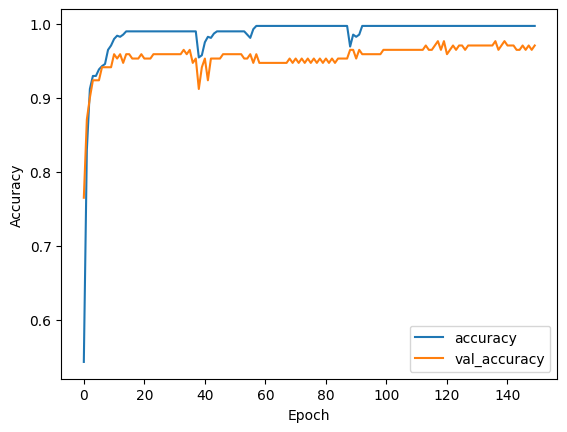

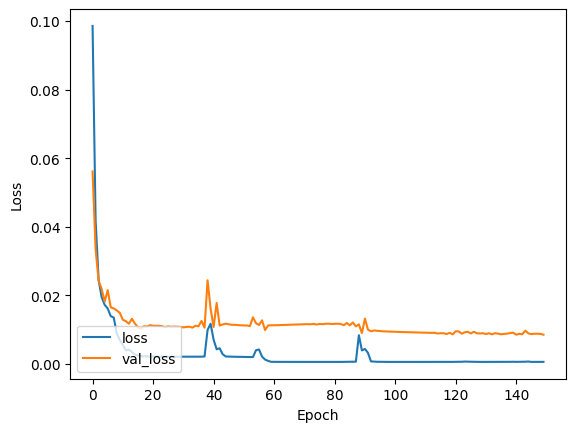

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9895 - loss: 0.0051
Test score: 0.00877121090888977
Test accuracy: 0.9764705896377563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Percentages per class:

[{'Achtung': '0.00%', 'Fuenfzig': '0.28%', 'Hundert': '0.03%', 'Stop': '0.06%', 'Vorfahrt': '99.52%', 'VofahrtGewaehren': '0.10%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Percentages per class:

[{'Achtung': '0.02%', 'Fuenfzig': '0.00%', 'Hundert': '0.02%', 'Stop': '0.00%', 'Vorfahrt': '99.93%', 'VofahrtGewaehren': '0.04%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Percentages per class:

[{'Achtung': '0.00%', 'Fuenfzig': '1.72%', 'Hundert': '98.28%', 'Stop': '0.00%', 'Vorfahrt': '0.00%', 'VofahrtGewaehren': '0.01%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Percentages per class:

[{'Achtung': '0.06%', 'Fuenfzig': '0.00%', 'Hundert': '0.02%', 'Stop': '0.00%', 'Vorfahrt': '71.75%', 'VofahrtGewaehren': '28.16%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Percentages per class:

[{'Achtung': '0.00

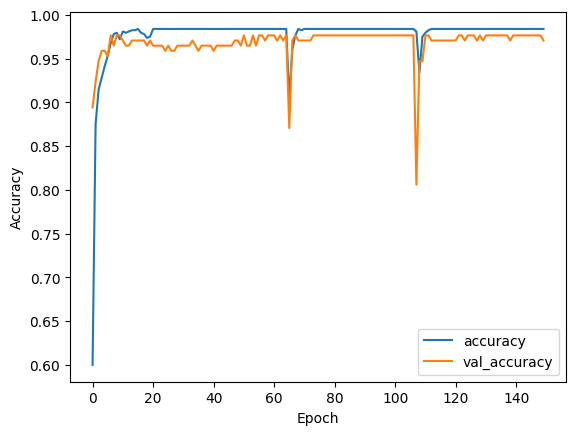

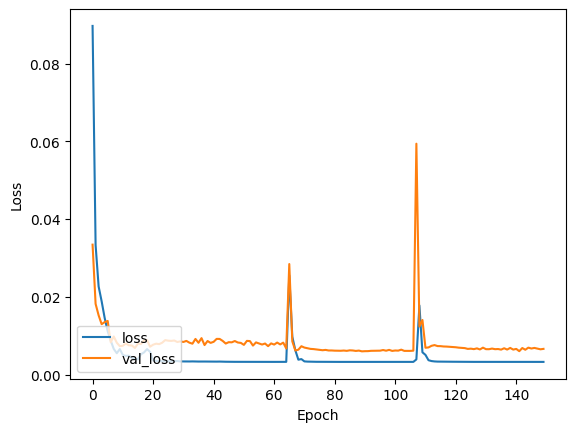

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9730 - loss: 0.0107
Test score: 0.00832902267575264
Test accuracy: 0.9764705896377563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Percentages per class:

[{'Achtung': '0.01%', 'Fuenfzig': '44.98%', 'Hundert': '0.03%', 'Stop': '31.04%', 'Vorfahrt': '23.77%', 'VofahrtGewaehren': '0.16%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Percentages per class:

[{'Achtung': '0.46%', 'Fuenfzig': '0.00%', 'Hundert': '0.04%', 'Stop': '0.03%', 'Vorfahrt': '99.43%', 'VofahrtGewaehren': '0.03%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Percentages per class:

[{'Achtung': '0.01%', 'Fuenfzig': '5.45%', 'Hundert': '93.75%', 'Stop': '0.00%', 'Vorfahrt': '0.78%', 'VofahrtGewaehren': '0.01%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Percentages per class:

[{'Achtung': '0.05%', 'Fuenfzig': '0.00%', 'Hundert': '0.05%', 'Stop': '0.02%', 'Vorfahrt': '12.70%', 'VofahrtGewaehren': '87.19%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Percentages per class:

[{'Achtung': '0

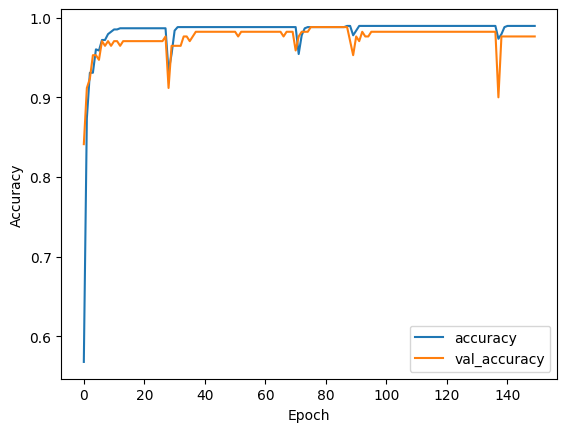

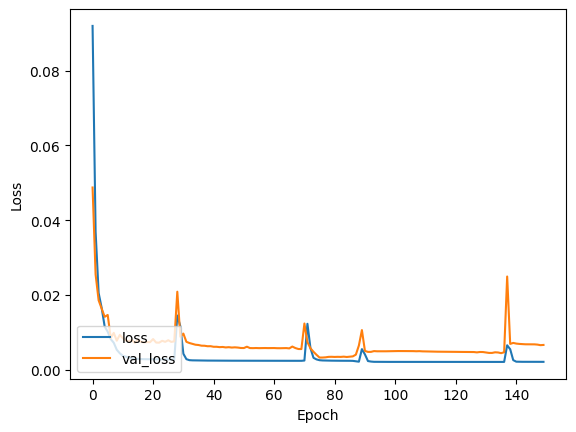

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9926 - loss: 0.0020   
Test score: 0.0032400768250226974
Test accuracy: 0.9882352948188782
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Percentages per class:

[{'Achtung': '0.00%', 'Fuenfzig': '0.09%', 'Hundert': '0.00%', 'Stop': '0.03%', 'Vorfahrt': '99.87%', 'VofahrtGewaehren': '0.01%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Percentages per class:

[{'Achtung': '0.47%', 'Fuenfzig': '0.00%', 'Hundert': '0.39%', 'Stop': '0.04%', 'Vorfahrt': '99.10%', 'VofahrtGewaehren': '0.00%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Percentages per class:

[{'Achtung': '0.14%', 'Fuenfzig': '0.17%', 'Hundert': '97.64%', 'Stop': '0.01%', 'Vorfahrt': '2.01%', 'VofahrtGewaehren': '0.03%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Percentages per class:

[{'Achtung': '0.83%', 'Fuenfzig': '0.00%', 'Hundert': '2.03%', 'Stop': '0.00%', 'Vorfahrt': '28.31%', 'VofahrtGewaehren': '68.82%'}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Percentages per class:

[{'Achtung':

In [ ]:
# =============================================================================
# Train multiple networks with differend image scales and neurons per layer
# =============================================================================

image_dims = [[64, 56],
              [64, 56],
              [64, 56],
              [64, 56],
              [32, 28],
              [32, 28],
              [32, 28],
              [32, 28]]

neurons_layers = [[128,6],
                  [84,6],
                  [64,6],
                  [32,6],
                  [128,6],
                  [84,6],
                  [64,6],
                  [32,6]]


# Train multiple times with different hyper parameters (dim img size, neurons per layer)

# Edit custom training parameters:
training_count = 26
batch_count = 4
epoch_count = 150

for img_size, num_neurons in zip(image_dims, neurons_layers):
    print("Training", training_count, "with image size", img_size, "and", num_neurons, "neurons per layer")
    train_signs_model(training_count, img_size, num_neurons, batch_count, epoch_count)
    print("#################################################\n")
    training_count += 1